In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ddm.models
from ddm import Sample
from itertools import product
from IPython.display import display
from ddm import Model, Fittable
from ddm.functions import fit_adjust_model, display_model
from ddm.models import NoiseConstant, BoundConstant, OverlayChain, OverlayNonDecision, OverlayPoissonMixture
import ddm.plot
from copy import deepcopy
import os

ModuleNotFoundError: No module named 'ddm'

In [11]:
import os
a = os.path.join('..', 'data')
os.listdir(a)

['allData.txt', 'CStimData.csv', 'test.mat']

## Load and Clean Data
We exlcude
1. Trials with coherence over threshold
2. Trials with rt under 0.1
3. Trials with invalid rt

In [2]:
columns =['LAB', 'Noise Color', 'Trial', 'Noise Trial', 'Session', 'Coherence', 'Correct Response', 'Reaction Time']
data = pd.read_csv('allData.txt', header = None, names=columns)

# Split LAB into Date and Lab Number
data['Date'] = [sub.split('_')[3] for sub in data['LAB']]
data['LAB'] = [sub.split('_')[2][-6:] for sub in data['LAB']]

# Select only Stimulation Trials
data = data[(data['Noise Color']=='white') | (data['Noise Color']=='pink') | (data['Noise Color']=='blue')]

# Get Subject IDs
idswitches = [True]+[True if data.iloc[n, 0] != data.iloc[n-1,0] else False for n in range(1,len(data))]
ids = [f'Sub{n:02d}' for n in np.cumsum(idswitches)]
data.insert(loc=0, column='ID', value=ids)
data = data.drop(columns='LAB')

# Get of Subject Numbers
SubjectList = np.unique(data['ID'])

# Clean from Invalid Reaction Times 
data=data.loc[~data['Reaction Time'].isnull() & data['Reaction Time']>0.1]

# bin Coherence to Percentages
data['Coherence'] = np.floor(data['Coherence']/10)
data['Coherence'] /= 100

data['Reaction Time'] = np.round(data['Reaction Time'],3)

# Display cleaned DataFrame
display(data)

,ID,Noise Color,Trial,Noise Trial,Session,Coherence,Correct Response,Reaction Time,Date
0,Sub01,white,1,1,1,0.40,1,0.783,04-10-2016
1,Sub01,white,2,2,1,0.40,1,0.616,04-10-2016
2,Sub01,white,3,3,1,0.40,1,0.616,04-10-2016
3,Sub01,white,4,4,1,0.40,1,0.516,04-10-2016
4,Sub01,white,5,5,1,0.20,1,0.583,04-10-2016
...,...,...,...,...,...,...,...,...,...
46151,Sub23,blue,916,240,4,0.01,1,1.116,06-10-2016
46152,Sub23,blue,917,241,4,0.02,0,1.550,06-10-2016
46153,Sub23,blue,918,242,4,0.02,0,1.366,06-10-2016
46154,Sub23,blue,919,243,4,0.04,1,1.283,06-10-2016


## Clean Data with Threshold
### Get Thresholds

In [3]:
windowsize = 4
perf_acc = 3

noisecolors=['white', 'blue', 'pink']
plotcolors = ['white', 'tab:blue', 'tab:pink']
threshold = []
for color, sub in product(noisecolors, np.unique(data['ID'])):
    color_df = data[(data['Noise Color'] == color) & (data['ID']==sub)]
    
    # Get Accuracy Dataframe
    acc_dict = {'Coherence':[], 'Accuracy':[]}
    for c in np.unique(color_df['Coherence']): 
        acc = np.mean(color_df.loc[color_df['Coherence']==c, 'Correct Response'])
        acc_dict['Coherence'].append(c)
        acc_dict['Accuracy'].append(acc)
    acc_df = pd.DataFrame(acc_dict)

    # Get Coherency Threshold 
    perf_idx = np.arange(len(acc_df))[acc_df['Accuracy']==1]
    for idx in perf_idx:
        window = acc_df.iloc[idx:idx+windowsize, 1]
        if np.sum(window==1)>=perf_acc:
            thresh_idx = idx-1
            thresh = acc_df.iloc[thresh_idx,0]
            break
    threshold.append([sub, color, thresh])
thresh_df = pd.DataFrame(threshold, columns=['ID', 'Color', 'Threshold'])

## Clean Data

In [4]:
data = data[data['ID']!='Sub09']
for row in thresh_df.iterrows():
    sub, color, thresh = row[1][:]
    data = data.loc[~((data['ID']==sub) & (data['Noise Color']==color) & (data['Coherence']>thresh))]
display(data)

,ID,Noise Color,Trial,Noise Trial,Session,Coherence,Correct Response,Reaction Time,Date
6,Sub01,white,7,7,1,0.05,1,1.166,04-10-2016
7,Sub01,white,8,8,1,0.02,0,1.216,04-10-2016
8,Sub01,white,9,9,1,0.02,0,0.600,04-10-2016
9,Sub01,white,10,10,1,0.03,1,0.733,04-10-2016
10,Sub01,white,11,11,1,0.04,1,0.517,04-10-2016
...,...,...,...,...,...,...,...,...,...
46151,Sub23,blue,916,240,4,0.01,1,1.116,06-10-2016
46152,Sub23,blue,917,241,4,0.02,0,1.550,06-10-2016
46153,Sub23,blue,918,242,4,0.02,0,1.366,06-10-2016
46154,Sub23,blue,919,243,4,0.04,1,1.283,06-10-2016


## Single Subject Example
## Load Data into pyddm

In [5]:
# Subject Lab001 dfs with different Noise colors
data = data.rename(columns={'Reaction Time':'rt', 'Correct Response':'correct', 'Coherence':'coherence', 'Noise Color':'noise_color'})

white_df = data.loc[(data['noise_color']=='white')  & (data['ID']=='Sub01'), ['correct', 'rt', 'coherence']]
white_sample = Sample.from_pandas_dataframe(white_df, rt_column_name="rt", correct_column_name="correct")

blue_df = data.loc[(data['noise_color']=='blue')  & (data['ID']=='Sub01'), ['correct', 'rt', 'coherence']]
blue_sample = Sample.from_pandas_dataframe(blue_df, rt_column_name="rt", correct_column_name="correct")

pink_df = data.loc[(data['noise_color']=='pink')  & (data['ID']=='Sub01'), ['correct', 'rt', 'coherence']]
pink_sample = Sample.from_pandas_dataframe(pink_df, rt_column_name="rt", correct_column_name="correct")

print('Example Sample - White Noise')
display(white_df)

Example Sample - White Noise


,correct,rt,coherence
6,1,1.166,0.05
7,0,1.216,0.02
8,0,0.600,0.02
9,1,0.733,0.03
10,1,0.517,0.04
...,...,...,...
242,0,1.899,0.02
243,1,1.083,0.02
244,1,1.783,0.02
245,0,1.666,0.02


## Plot Correct Response vs. Reaction Time - White Noise

Text(0.5, 1.0, 'Pink Noise - Correct Trials')

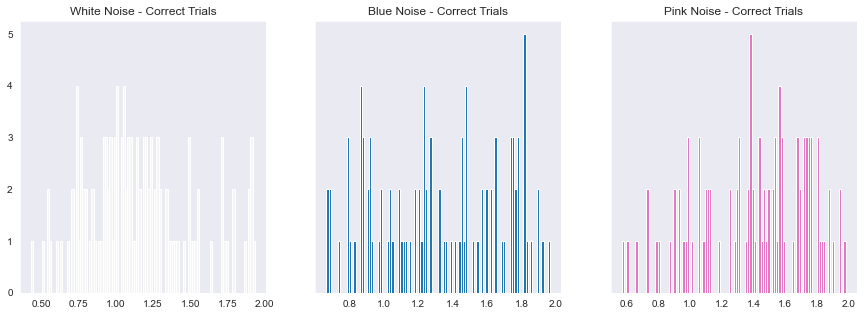

In [6]:
sns.set_style('dark')
fig, ax = plt.subplots(1,3, figsize=(15,5), sharey=True)
correct_white = white_df[white_df['correct']==1]
ax[0].hist(white_df.loc[white_df['correct']==1, 'rt'], bins=100, color='whitesmoke');
ax[0].set_title('White Noise - Correct Trials')
ax[1].hist(blue_df.loc[blue_df['correct']==1, 'rt'], bins=100, color='tab:blue');
ax[1].set_title('Blue Noise - Correct Trials')
ax[2].hist(pink_df.loc[pink_df['correct']==1, 'rt'], bins=100, color='tab:pink');
ax[2].set_title('Pink Noise - Correct Trials')

## Set up Drift Diffusion Model

In [7]:
class DriftCoherence(ddm.models.Drift):
    name = "Drift depends linearly on coherence"
    # Parameter that should be included in the ddm
    required_parameters = ["driftcoherence"] 
    # Task Parameter, i.e. coherence
    required_conditions = ["coherence"] 
    
    # Define the get_drift function
    def get_drift(self, conditions, **kwargs):
        return self.driftcoherence * conditions['coherence']

# Set up Model with Drift depending on Coherence
model = Model(name='Noise Model - Drift varies with coherence',
             drift=DriftCoherence(driftcoherence=Fittable(minval=0, maxval=20)),
             noise=NoiseConstant(noise=1),
             bound=BoundConstant(B=Fittable(minval=.1, maxval=1.5)),
             overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.4)),
                                            OverlayPoissonMixture(pmixturecoef=.02,
                                                                  rate=1)]),
            dx=.01, dt=.01, T_dur=2)

## Fit Model

In [8]:
fit_adjust_model(sample=white_sample, model=model, verbose=False)
white_fit = deepcopy(model)
#fit_model_blue = fit_adjust_model(sample=blue_sample, model=model, verbose=False)
#blue_fit = deepcopy(model)
#fit_model_pink = fit_adjust_model(sample=pink_sample, model=model, verbose=False)
#pink_fit = deepcopy(model)

differential_evolution step 1: f(x)= 218.945
differential_evolution step 2: f(x)= 218.945
differential_evolution step 3: f(x)= 217.312
differential_evolution step 4: f(x)= 216.548
differential_evolution step 5: f(x)= 216.548
differential_evolution step 6: f(x)= 216.281
differential_evolution step 7: f(x)= 215.824
differential_evolution step 8: f(x)= 215.806
differential_evolution step 9: f(x)= 215.806
differential_evolution step 10: f(x)= 215.766
differential_evolution step 11: f(x)= 215.766
Params [9.45877865 0.97339557 0.39506813] gave 215.75781798882718


## Plot Model Fits

Model Noise Model - Drift varies with coherence information:
Drift component DriftCoherence:
    Drift depends linearly on coherence
    Fitted parameters:
    - driftcoherence: 9.458779
Noise component NoiseConstant:
    constant
    Fixed parameters:
    - noise: 1.000000
Bound component BoundConstant:
    constant
    Fitted parameters:
    - B: 0.973396
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayChain:
    Overlay component OverlayNonDecision:
        Add a non-decision by shifting the histogram
        Fitted parameters:
        - nondectime: 0.395068
    Overlay component OverlayPoissonMixture:
        Poisson distribution mixture model (lapse rate)
        Fixed parameters:
        - pmixturecoef: 0.020000
        - rate: 1.000000
Fit information:
    Loss function: Negative log likelihood
    Loss function value: 215.75781798882718
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
      

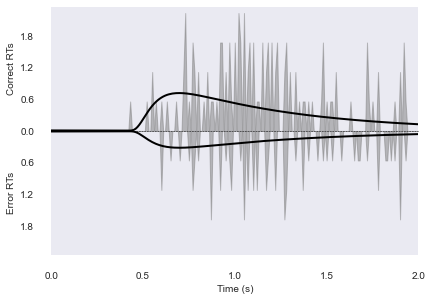

In [9]:
display_model(white_fit)
ddm.plot.plot_fit_diagnostics(model=white_fit, sample=white_sample)

In [10]:
display_model(blue_fit)
ddm.plot.plot_fit_diagnostics(model=blue_fit, sample=blue_sample)

NameError: name 'blue_fit' is not defined

In [ ]:
display_model(pink_fit)
ddm.plot.plot_fit_diagnostics(model=pink_fit, sample=pink_sample)